# Exploratory Analysis — Pindamonhangaba Climate Data (1940–2025)

> **Purpose**: Quick sanity checks and visual exploration of the raw merged CSV before processing.
>
> **Input**: `data/raw/pindamonhangaba_1940_2025.csv` (produced by `fetch_climate_data.py`)
>
> Run cells in order. Requires: `pandas`, `numpy`, `matplotlib`, `seaborn`, `scipy`.

In [2]:
# ── Cell 1: Load raw CSV, display .head(), .info(), .describe() ──────────────

from pathlib import Path

import numpy as np
import pandas as pd

# Resolve path relative to this notebook's location
NOTEBOOK_DIR = Path(".").resolve()
RAW_CSV = NOTEBOOK_DIR.parent / "raw" / "pindamonhangaba_1940_2025.csv"

if not RAW_CSV.exists():
    raise FileNotFoundError(
        f"Raw CSV not found at {RAW_CSV}.\n"
        "Run `python data/scripts/fetch_climate_data.py` first."
    )

df = pd.read_csv(RAW_CSV, parse_dates=["date"])

print(f"Shape: {df.shape}")
print(f"Date range: {df['date'].min().date()} → {df['date'].max().date()}")
print(f"Expected rows (1940-01-01 to 2025-12-31): {(pd.Timestamp('2025-12-31') - pd.Timestamp('1940-01-01')).days + 1}")
print()

print("── head() ──────────────────────────────────────────────")
display(df.head(10))

print("\n── info() ──────────────────────────────────────────────")
df.info()

print("\n── describe() ──────────────────────────────────────────")
display(df.describe().round(2))

Shape: (31047, 7)
Date range: 1940-01-01 → 2025-12-31
Expected rows (1940-01-01 to 2025-12-31): 31412

── head() ──────────────────────────────────────────────


,date,temp_max,temp_min,temp_mean,precipitation,humidity,wind_max
0,1940-01-01,24.9,17.9,20.8,NaN,90,9.4
1,1940-01-02,25.8,19.2,22.6,5.0,81,10.4
2,1940-01-03,27.3,19.4,22.9,7.2,82,11.4
3,1940-01-04,25.7,19.0,22.6,8.0,84,14.0
4,1940-01-05,25.7,19.8,22.1,23.1,91,9.7
5,1940-01-06,27.5,19.1,22.8,25.3,89,9.7
6,1940-01-07,27.6,20.0,22.9,16.9,86,8.9
7,1940-01-08,27.0,19.4,22.1,28.9,89,9.7
8,1940-01-09,25.6,19.6,22.1,19.4,91,7.6
9,1940-01-10,24.2,20.2,21.6,26.3,93,7.6



── info() ──────────────────────────────────────────────
<class 'pandas.DataFrame'>
RangeIndex: 31047 entries, 0 to 31046
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           31047 non-null  datetime64[us]
 1   temp_max       31047 non-null  float64       
 2   temp_min       31047 non-null  float64       
 3   temp_mean      31047 non-null  float64       
 4   precipitation  31046 non-null  float64       
 5   humidity       31047 non-null  int64         
 6   wind_max       31047 non-null  float64       
dtypes: datetime64[us](1), float64(5), int64(1)
memory usage: 1.7 MB

── describe() ──────────────────────────────────────────


,date,temp_max,temp_min,temp_mean,precipitation,humidity,wind_max
count,31047,31047.00,31047.00,31047.00,31046.00,31047.00,31047.00
mean,1982-10-08 18:21:58.388250,25.77,16.03,20.53,4.38,78.22,9.50
min,1940-01-01 00:00:00,9.40,1.30,8.00,0.00,29.00,3.40
25%,1961-04-01 12:00:00,23.50,13.70,18.40,0.00,73.00,7.30
50%,1982-07-02 00:00:00,26.00,16.60,20.80,0.70,79.00,8.90
75%,2004-09-30 12:00:00,28.40,18.70,22.80,5.80,85.00,11.10
max,2025-12-31 00:00:00,38.20,24.70,30.50,153.60,98.00,27.80
std,NaN,3.66,3.28,3.04,7.65,9.12,2.96


Total NaN values across all columns: 1
Missing per column:
temp_max         0
temp_min         0
temp_mean        0
precipitation    1
humidity         0
wind_max         0


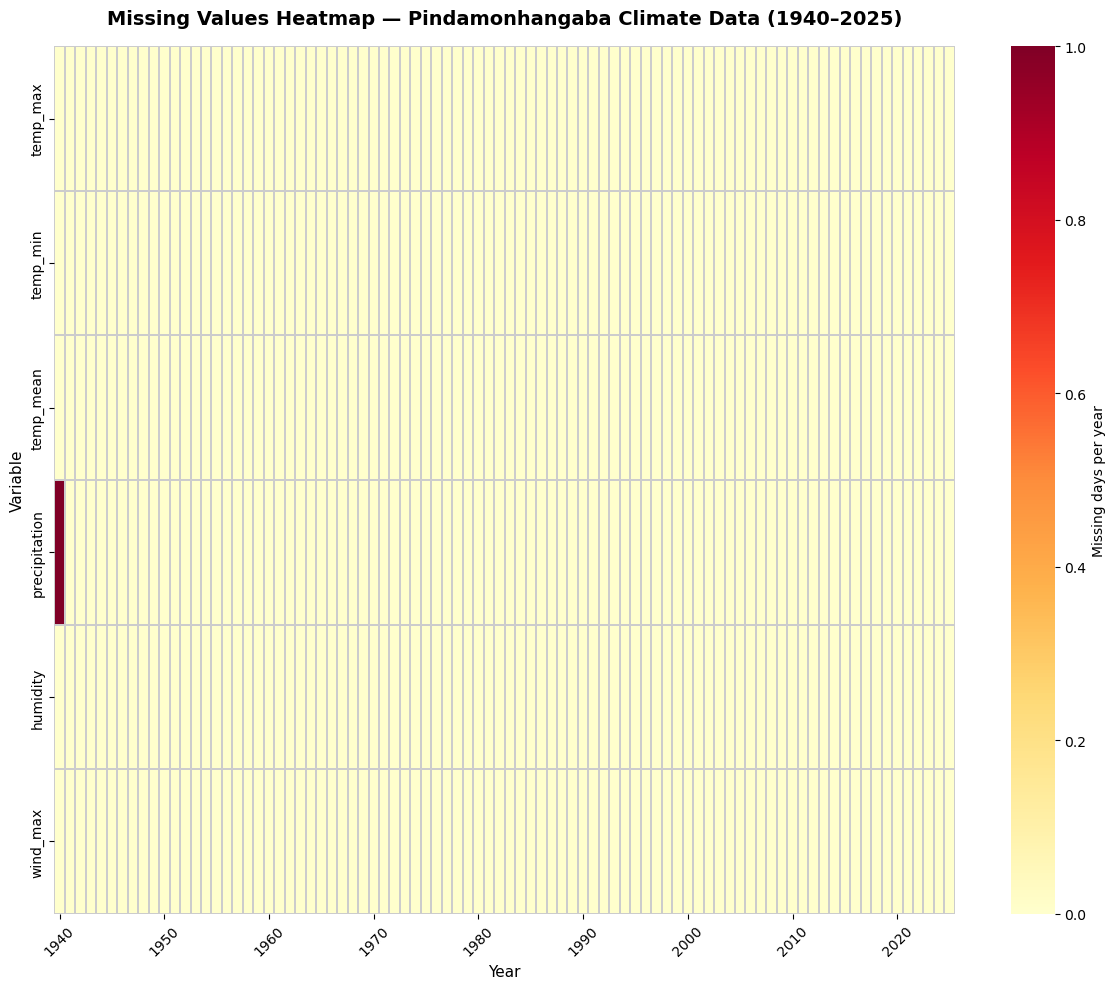

Saved → missing_values_heatmap.png


In [3]:
# ── Cell 2: Missing values heatmap (seaborn) ──────────────────────────────────
#
# Strategy: pivot the boolean NaN mask to a (year × month) grid per column,
# then show a heatmap of the fraction of missing days per year-month.
# This makes it easy to spot systematic gaps (e.g., entire months missing).

import matplotlib.pyplot as plt
import seaborn as sns

# Add helper columns
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

COLS = ["temp_max", "temp_min", "temp_mean", "precipitation", "humidity", "wind_max"]

# Build a (year × variable) missing-count matrix
missing_by_year = (
    df.set_index("date")[COLS]
    .isnull()
    .resample("YE")  # resample to year-end
    .sum()
    .astype(int)
)
missing_by_year.index = missing_by_year.index.year  # use integer year labels

total_missing = missing_by_year.values.sum()
print(f"Total NaN values across all columns: {total_missing}")
print(f"Missing per column:\n{df[COLS].isnull().sum().to_string()}")

fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(
    missing_by_year.T,
    ax=ax,
    cmap="YlOrRd",
    linewidths=0.3,
    linecolor="#cccccc",
    annot=False,
    cbar_kws={"label": "Missing days per year"},
    xticklabels=10,  # show every 10th year to avoid crowding
)

ax.set_title(
    "Missing Values Heatmap — Pindamonhangaba Climate Data (1940–2025)",
    fontsize=14, fontweight="bold", pad=16,
)
ax.set_xlabel("Year", fontsize=11)
ax.set_ylabel("Variable", fontsize=11)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.savefig(NOTEBOOK_DIR / "missing_values_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved → missing_values_heatmap.png")

C:\Users\usain\AppData\Local\Temp\ipykernel_11160\1371449393.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


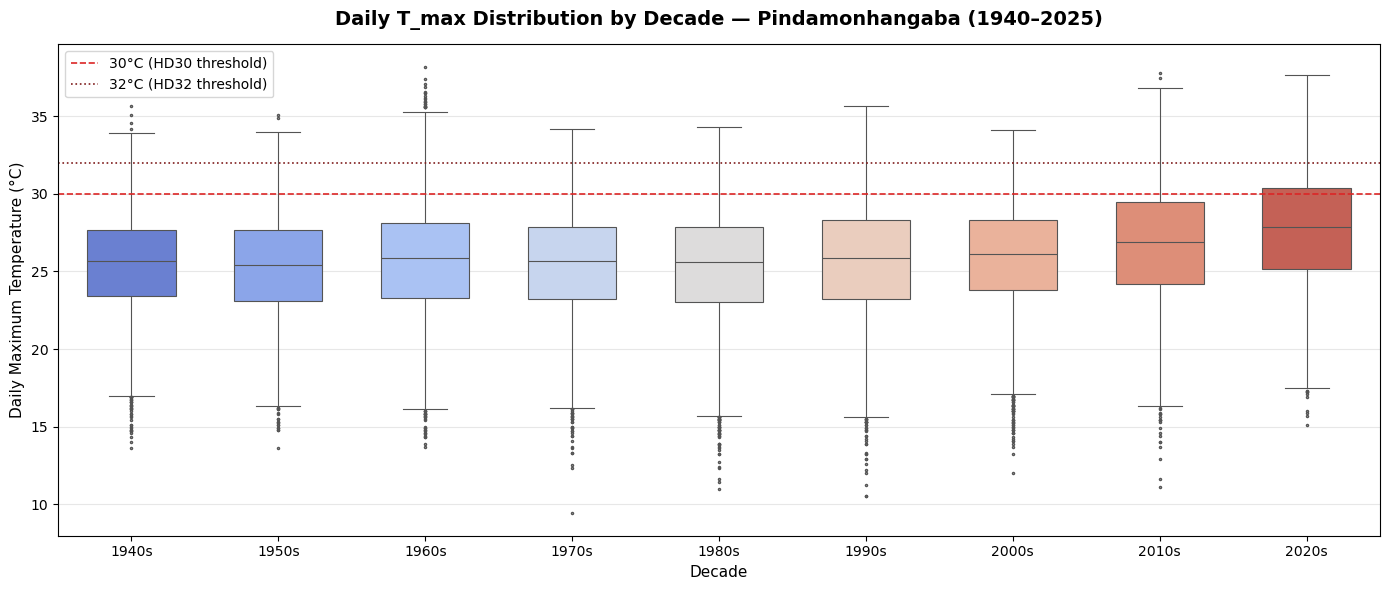

Saved → tmax_boxplot_by_decade.png


In [4]:
# ── Cell 3: Annual T_max distribution — boxplot by decade ────────────────────
#
# Each box = distribution of daily T_max values within that decade.
# A rightward shift of the box over time = warming signal.

import matplotlib.patches as mpatches

# Assign decade label
df["decade"] = (df["year"] // 10 * 10).astype(str) + "s"

# Ordered list of decades present in the data
decades_ordered = sorted(df["decade"].unique())

# Palette: cool → warm gradient across decades
palette = sns.color_palette("coolwarm", n_colors=len(decades_ordered))

fig, ax = plt.subplots(figsize=(14, 6))

sns.boxplot(
    data=df,
    x="decade",
    y="temp_max",
    order=decades_ordered,
    palette=palette,
    width=0.6,
    fliersize=1.5,
    linewidth=0.8,
    ax=ax,
)

# Reference line at 30°C (HD30 threshold)
ax.axhline(30, color="#dc2626", linestyle="--", linewidth=1.2, label="30°C (HD30 threshold)")
ax.axhline(32, color="#7f1d1d", linestyle=":",  linewidth=1.2, label="32°C (HD32 threshold)")

ax.set_title(
    "Daily T_max Distribution by Decade — Pindamonhangaba (1940–2025)",
    fontsize=14, fontweight="bold", pad=14,
)
ax.set_xlabel("Decade", fontsize=11)
ax.set_ylabel("Daily Maximum Temperature (°C)", fontsize=11)
ax.legend(fontsize=10)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig(NOTEBOOK_DIR / "tmax_boxplot_by_decade.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved → tmax_boxplot_by_decade.png")

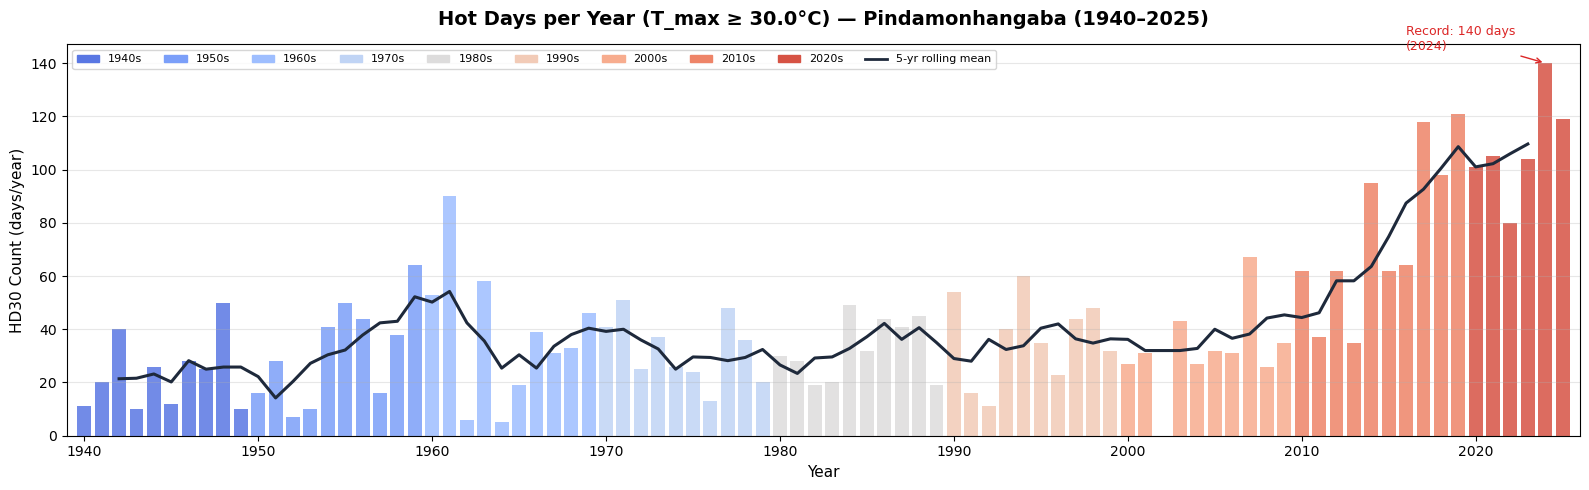

Saved → hd30_per_year.png

HD30 summary:
         year   hd30
count    85.0   85.0
mean   1982.3   43.0
std      25.0   29.4
min    1940.0    5.0
25%    1961.0   25.0
50%    1982.0   36.0
75%    2004.0   51.0
max    2025.0  140.0


In [5]:
# ── Cell 4: HD30 count per year — bar chart ───────────────────────────────────
#
# HD30 = days per year where T_max ≥ 30°C.
# Bars are coloured by decade to make the trend visually obvious.
# A 5-year rolling mean is overlaid to smooth noise.

HD30_THRESHOLD = 30.0

hd30_annual = (
    df.groupby("year")["temp_max"]
    .apply(lambda s: (s >= HD30_THRESHOLD).sum())
    .rename("hd30")
    .reset_index()
)

hd30_annual["decade"] = (hd30_annual["year"] // 10 * 10).astype(str) + "s"
hd30_annual["rolling5"] = hd30_annual["hd30"].rolling(5, center=True).mean()

# Map decade → colour
unique_decades = sorted(hd30_annual["decade"].unique())
decade_colors = dict(zip(unique_decades, sns.color_palette("coolwarm", len(unique_decades))))
bar_colors = hd30_annual["decade"].map(decade_colors)

fig, ax = plt.subplots(figsize=(16, 5))

ax.bar(hd30_annual["year"], hd30_annual["hd30"], color=bar_colors, width=0.8, alpha=0.85)
ax.plot(
    hd30_annual["year"], hd30_annual["rolling5"],
    color="#1e293b", linewidth=2.2, label="5-yr rolling mean",
)

# Annotate the record year
record_row = hd30_annual.loc[hd30_annual["hd30"].idxmax()]
ax.annotate(
    f"Record: {int(record_row['hd30'])} days\n({int(record_row['year'])})",
    xy=(record_row["year"], record_row["hd30"]),
    xytext=(record_row["year"] - 8, record_row["hd30"] + 5),
    arrowprops=dict(arrowstyle="->", color="#dc2626"),
    fontsize=9, color="#dc2626",
)

# Legend patches for decades
legend_patches = [
    mpatches.Patch(color=c, label=d) for d, c in decade_colors.items()
]
legend_patches.append(
    plt.Line2D([0], [0], color="#1e293b", linewidth=2, label="5-yr rolling mean")
)
ax.legend(handles=legend_patches, fontsize=8, ncol=len(unique_decades) + 1,
          loc="upper left", framealpha=0.8)

ax.set_title(
    f"Hot Days per Year (T_max ≥ {HD30_THRESHOLD}°C) — Pindamonhangaba (1940–2025)",
    fontsize=14, fontweight="bold", pad=14,
)
ax.set_xlabel("Year", fontsize=11)
ax.set_ylabel("HD30 Count (days/year)", fontsize=11)
ax.set_xlim(hd30_annual["year"].min() - 1, hd30_annual["year"].max() + 1)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig(NOTEBOOK_DIR / "hd30_per_year.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved → hd30_per_year.png")
print(f"\nHD30 summary:")
print(hd30_annual[["year", "hd30"]].describe().round(1).to_string())

In [6]:
# ── Cell 5: Validate T_min ≤ T_mean ≤ T_max ──────────────────────────────────
#
# ERA5 reanalysis can occasionally produce model artifacts where T_min > T_max.
# This cell asserts the ordering and reports any violations.
# The process_climate_data.py script will swap these values; this cell just flags them.

print("=" * 60)
print("Validation: T_min ≤ T_mean ≤ T_max")
print("=" * 60)

# Drop rows where any of the three columns is NaN (can't validate)
df_valid = df.dropna(subset=["temp_min", "temp_mean", "temp_max"]).copy()
n_total = len(df_valid)

# ── Violation 1: T_min > T_max ────────────────────────────────────────────────
mask_min_gt_max = df_valid["temp_min"] > df_valid["temp_max"]
violations_min_gt_max = df_valid[mask_min_gt_max]

print(f"\n[1] T_min > T_max violations: {len(violations_min_gt_max)} / {n_total} rows")
if len(violations_min_gt_max) > 0:
    print("    Sample violations:")
    display(
        violations_min_gt_max[["date", "temp_min", "temp_mean", "temp_max"]]
        .head(10)
        .to_string(index=False)
    )
    print("    ⚠ These will be swapped by process_climate_data.py")
else:
    print("    ✓ No violations found.")

# ── Violation 2: T_mean < T_min ───────────────────────────────────────────────
mask_mean_lt_min = df_valid["temp_mean"] < df_valid["temp_min"]
violations_mean_lt_min = df_valid[mask_mean_lt_min]

print(f"\n[2] T_mean < T_min violations: {len(violations_mean_lt_min)} / {n_total} rows")
if len(violations_mean_lt_min) > 0:
    display(
        violations_mean_lt_min[["date", "temp_min", "temp_mean", "temp_max"]]
        .head(10)
        .to_string(index=False)
    )
    print("    ⚠ Will be logged by process_climate_data.py")
else:
    print("    ✓ No violations found.")

# ── Violation 3: T_mean > T_max ───────────────────────────────────────────────
mask_mean_gt_max = df_valid["temp_mean"] > df_valid["temp_max"]
violations_mean_gt_max = df_valid[mask_mean_gt_max]

print(f"\n[3] T_mean > T_max violations: {len(violations_mean_gt_max)} / {n_total} rows")
if len(violations_mean_gt_max) > 0:
    display(
        violations_mean_gt_max[["date", "temp_min", "temp_mean", "temp_max"]]
        .head(10)
        .to_string(index=False)
    )
    print("    ⚠ Will be logged by process_climate_data.py")
else:
    print("    ✓ No violations found.")

# ── Sanity bounds ─────────────────────────────────────────────────────────────
print("\n── Sanity bounds (regional plausibility) ────────────────")
out_of_range_max = df_valid[df_valid["temp_max"] >= 50]
out_of_range_min = df_valid[df_valid["temp_min"] <= -10]
print(f"T_max ≥ 50°C: {len(out_of_range_max)} rows  (expected 0 for Pindamonhangaba)")
print(f"T_min ≤ -10°C: {len(out_of_range_min)} rows  (expected 0 for Pindamonhangaba)")

# ── Summary ───────────────────────────────────────────────────────────────────
total_violations = (
    len(violations_min_gt_max)
    + len(violations_mean_lt_min)
    + len(violations_mean_gt_max)
    + len(out_of_range_max)
    + len(out_of_range_min)
)

print("\n" + "=" * 60)
if total_violations == 0:
    print("✅ All validation checks passed. Data is clean.")
else:
    print(f"⚠  {total_violations} total violation(s) found — see details above.")
    print("   Run process_climate_data.py to apply corrections.")
print("=" * 60)

Validation: T_min ≤ T_mean ≤ T_max

[1] T_min > T_max violations: 0 / 31047 rows
    ✓ No violations found.

[2] T_mean < T_min violations: 0 / 31047 rows
    ✓ No violations found.

[3] T_mean > T_max violations: 0 / 31047 rows
    ✓ No violations found.

── Sanity bounds (regional plausibility) ────────────────
T_max ≥ 50°C: 0 rows  (expected 0 for Pindamonhangaba)
T_min ≤ -10°C: 0 rows  (expected 0 for Pindamonhangaba)

✅ All validation checks passed. Data is clean.
